### Background

The field of medical image processing with deep learning harnesses cutting-edge algorithms to improve the accuracy and efficiency of diagnostic tasks such as image segmentation and disease detection. With fast.ai, we propose to exploit its high-level abstractions and easy-to-use interfaces to potentially overcome the complexities typically associated with PyTorch implementations. This approach not only simplifies the development of deep learning models but also opens up new avenues for optimizing performance with less code complexity.

###  Methodology

The project employs the fast.ai library to construct a model that efficiently handles multi-label classification tasks, essential for diagnosing multiple pathologies from single imaging studies. The comparison focuses on key aspects such as training time, ease of model adjustments, and the accuracy of results. We aim to fine-tune the models using advanced techniques like data augmentation and transfer learning, which are crucial in handling the diverse and imbalanced datasets typical in medical imaging.

##### Data import an preparation

In [1]:
from fastai.vision.all import *
from pathlib import Path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from torch import nn
import torch


In [2]:
image_root = Path('/Users/zikih/OneDrive/桌面/项目/clip_model/handle_labels/images/')
csv_root = Path('/Users/zikih/OneDrive/桌面/项目/clip_model/handle_labels/Data_Entry_2017_v2020.csv')

In [3]:
# Load the dataset
df = pd.read_csv(csv_root)

In [4]:
# Assuming 'image_root' and 'df' are defined as in your code
missing_files = []
found_files = []

for idx, image_name in enumerate(df['Image Index']):
    image_path = image_root / image_name
    if not image_path.exists():
        missing_files.append((image_name, str(image_path)))
    else:
        found_files.append((image_name, str(image_path)))

    # Optionally print every 100th path to check patterns
    if idx % 100 == 0:
        print(f"Checked {image_name}: Path exists - {image_path.exists()}")

# Print out missing files to debug
print("Missing files:", missing_files[:10])  # Print first 10 missing files for review

# Update DataFrame to only include found images
df = df[df['Image Index'].isin([f[0] for f in found_files])].reset_index(drop=True)


Checked 00000001_000.png: Path exists - False
Checked 00000023_000.png: Path exists - False
Checked 00000041_001.png: Path exists - False
Checked 00000070_000.png: Path exists - False
Checked 00000099_009.png: Path exists - False
Checked 00000118_006.png: Path exists - False
Checked 00000148_002.png: Path exists - False
Checked 00000181_004.png: Path exists - False
Checked 00000193_015.png: Path exists - False
Checked 00000217_000.png: Path exists - False
Checked 00000246_016.png: Path exists - False
Checked 00000271_002.png: Path exists - False
Checked 00000300_000.png: Path exists - False
Checked 00000327_000.png: Path exists - False
Checked 00000368_008.png: Path exists - False
Checked 00000391_008.png: Path exists - False
Checked 00000427_001.png: Path exists - False
Checked 00000459_052.png: Path exists - False
Checked 00000468_017.png: Path exists - False
Checked 00000491_018.png: Path exists - False
Checked 00000508_002.png: Path exists - False
Checked 00000546_000.png: Path exi

In [5]:
# Extract labels and count their frequencies
all_labels = [label.strip() for sublist in df['Finding Labels'].str.split('|') for label in sublist]
label_counts = Counter(all_labels)

#### Data balance check 

Label Percentages:
No Finding: 50.22%
Infiltration: 11.97%
Effusion: 7.49%
Mass: 2.59%
Atelectasis: 7.45%
Cardiomegaly: 1.67%
Pneumothorax: 3.94%
Fibrosis: 1.73%
Consolidation: 2.95%
Pneumonia: 1.00%
Edema: 0.89%
Nodule: 3.78%
Emphysema: 1.62%
Hernia: 0.16%
Pleural_Thickening: 2.54%


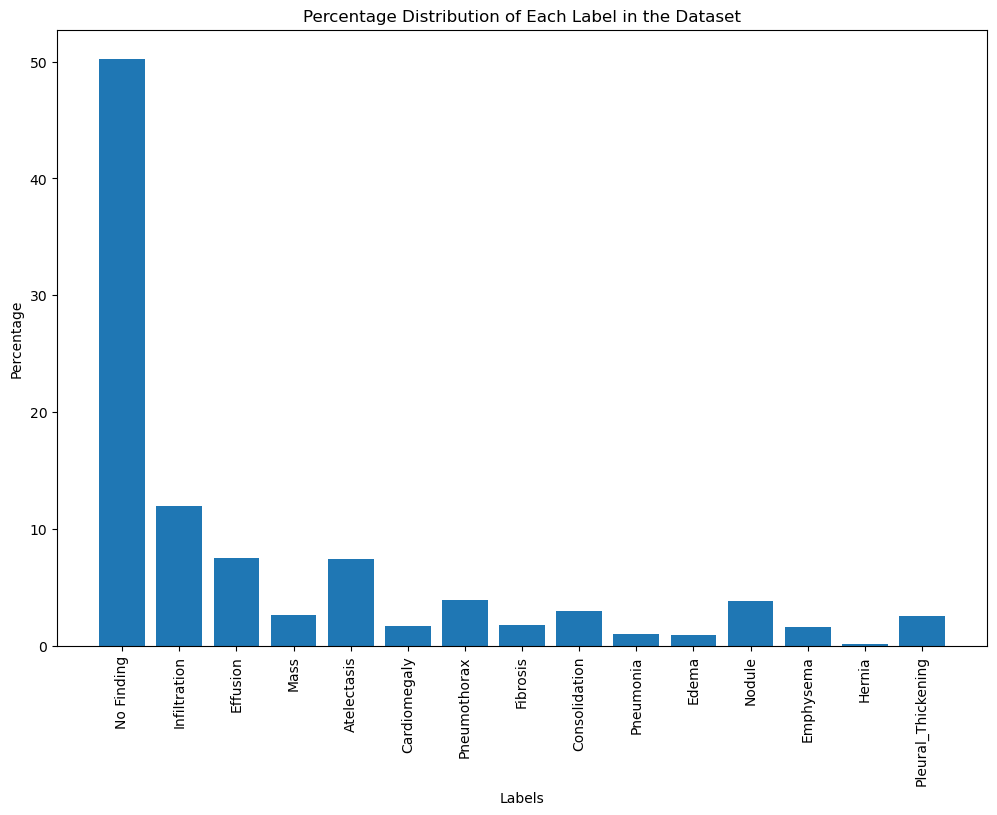

In [6]:
# Calculate total number of label occurrences to find percentages
total_labels = sum(label_counts.values())

# Calculate the percentage of each label
label_percentages = {label: count / total_labels * 100 for label, count in label_counts.items()}


# Print percentages for a textual overview and plot the distribution
print("Label Percentages:")
for label, percentage in label_percentages.items():
    print(f"{label}: {percentage:.2f}%")

# Create a bar chart to visualize the percentage distribution
plt.figure(figsize=(12, 8))
plt.bar(label_percentages.keys(), label_percentages.values())
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Each Label in the Dataset')
plt.xticks(rotation=90)
plt.show()


The label percentages in dataset reveal a significant imbalance among the classes, with "No Finding" overwhelmingly dominating at over 50%. This imbalance can lead to a model biased towards predicting "No Finding" more frequently, while underrepresenting minority conditions like "Hernia," "Edema," and "Pneumonia." Such disparities pose challenges in training and may hinder the model's ability to accurately detect rarer conditions. Enhanced evaluation metrics and resampling techniques could be employed to mitigate this imbalance, ensuring more equitable training across all classes. From this analysis, it is evident that the dataset is imbalanced, necessitating strategies to address this issue for more effective model training and diagnostic performance

### Class weight normalization 

To address the class imbalance evident in the dataset, normalizing class weights is a crucial strategy. This technique involves assigning weights to each class inversely proportional to their frequency in the dataset, ensuring that rarer conditions contribute more significantly to the loss during model training. 

Normalized Class Weights:
No Finding: 0.0490
Infiltration: 0.1991
Effusion: 0.3107
Mass: 0.8046
Atelectasis: 0.3124
Cardiomegaly: 1.1423
Pneumothorax: 0.5590
Fibrosis: 1.1123
Consolidation: 0.7206
Pneumonia: 1.6599
Edema: 1.7901
Nodule: 0.5797
Emphysema: 1.1739
Hernia: 3.7685
Pleural_Thickening: 0.8179


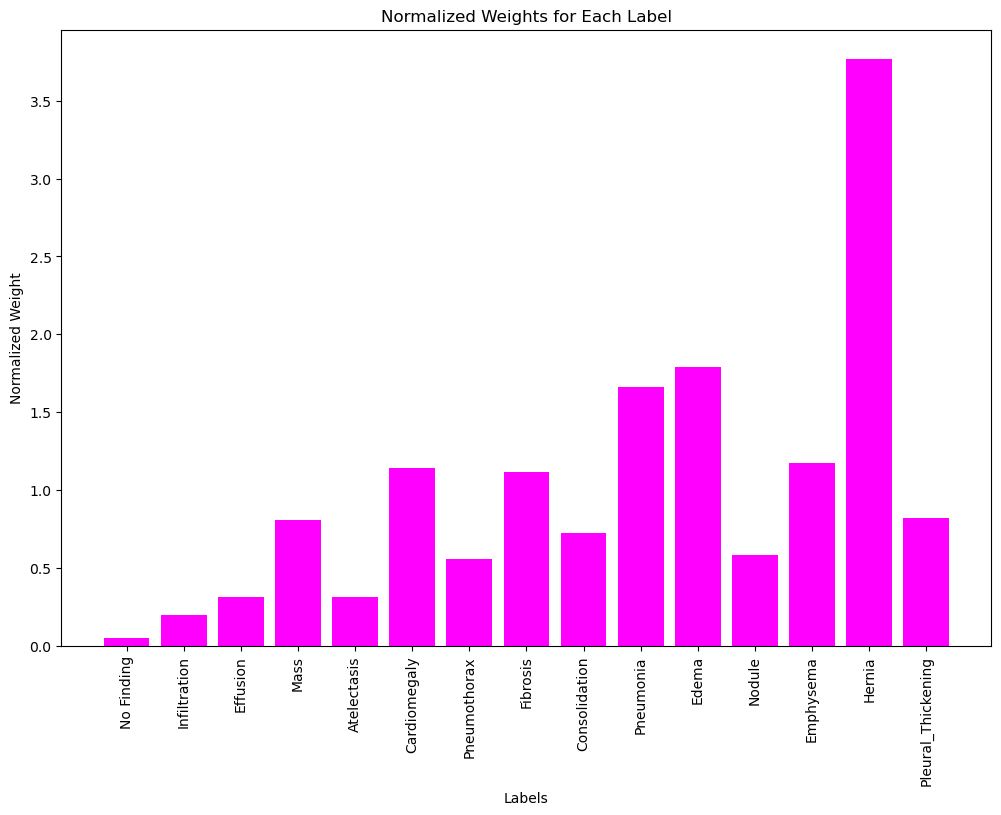

In [7]:
# Adding a smoothing factor
smoothing_factor = 0.005
weights = {label: 1 / (percentage / 100 + smoothing_factor) for label, percentage in label_percentages.items()}

# Normalize weights to make sure they sum to 1 or to the number of classes
total_weight = sum(weights.values())
normalized_weights = {label: weight / total_weight * len(weights) for label, weight in weights.items()}

# Print normalized weights
print("Normalized Class Weights:")
for label, weight in normalized_weights.items():
    print(f"{label}: {weight:.4f}")

# Optionally visualize the weight distribution
plt.figure(figsize=(12, 8))
plt.bar(normalized_weights.keys(), normalized_weights.values(), color='magenta')
plt.xlabel('Labels')
plt.ylabel('Normalized Weight')
plt.title('Normalized Weights for Each Label')
plt.xticks(rotation=90)
plt.show()


In [8]:
weights_tensor = torch.tensor(list(normalized_weights.values()), dtype=torch.float32)

This approach helps prevent the model from being overly biased towards more frequent classes like "No Finding" and encourages it to learn more about underrepresented conditions. The normalized weights you provided, such as 3.7685 for "Hernia" and 1.7901 for "Edema", significantly elevate the influence of these minority classes during training. As a result, the model is more attentive to all classes, potentially enhancing its diagnostic accuracy across a more diverse range of medical conditions. 

In [9]:
# Custom Focal Loss Function
class FocalLoss(nn.Module):
    def __init__(self, normalized_weights=None, gamma=2.0, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        # Renaming to weights_tensor to clarify that these are the calculated weights
        self.weights_tensor = nn.Parameter(torch.tensor(list(normalized_weights.values()), dtype=torch.float32), requires_grad=False) if normalized_weights is not None else None
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.weights_tensor is not None:
            self.weights_tensor = self.weights_tensor.to(inputs.device)

        BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss

        if self.weights_tensor is not None:
            # Applying weights_tensor to the loss
            weighted_F_loss = F_loss * self.weights_tensor.expand_as(targets)
        else:
            weighted_F_loss = F_loss

        if self.reduction == 'mean':
            return weighted_F_loss.mean()
        else:
            return weighted_F_loss.sum()


 implementing a custom Focal Loss function to enhance our model's sensitivity and specificity in detecting various medical conditions from imbalanced datasets. Focal Loss is particularly suited for addressing class imbalance by modifying the cross-entropy loss such that it down-weights the loss contributed by well-classified examples and focuses more on hard, misclassified examples. This is achieved through two parameters: gamma, which adjusts the rate at which easy examples are down-weighted; and alpha, which provides a balancing factor for classes. 

In [10]:
# Define paths and functions for model data preparation
def get_x(r): return image_root / r['Image Index']
def get_y(r): return r['Finding Labels'].split('|')

the functions get_x and get_y streamline the data preparation process by efficiently linking image files and their corresponding labels for machine learning training. 

#### Block define 

In [11]:
# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.3),
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
)


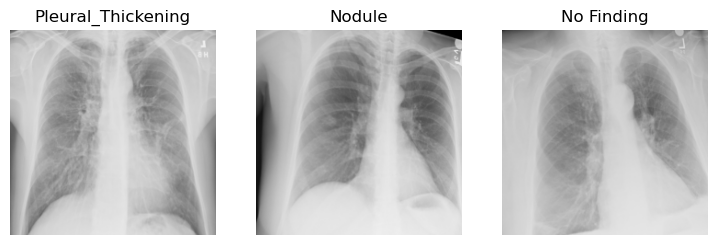

In [12]:
# Load data into DataLoaders
dls = dblock.dataloaders(df, bs=64)

dls.show_batch(nrows=1, ncols=3)   

In [13]:

def precision_multi(inp, targ, thresh=0.25, sigmoid=True):
    if sigmoid:
        inp = inp.sigmoid()
    inp = (inp > thresh).byte()
    targ = targ.byte()
    true_positive = (inp & targ).sum(dim=0).float()
    predicted_positive = inp.sum(dim=0).float()
    precision_scores = torch.where(predicted_positive > 0, true_positive / predicted_positive, torch.tensor(0.0))
    return precision_scores.mean()

def recall_multi(inp, targ, thresh=0.25, sigmoid=True):
    if sigmoid:
        inp = inp.sigmoid()
    inp = (inp > thresh).byte()
    targ = targ.byte()
    true_positive = (inp & targ).sum(dim=0).float()
    actual_positive = targ.sum(dim=0).float()
    recall_scores = torch.where(actual_positive > 0, true_positive / actual_positive, torch.tensor(0.0))
    return recall_scores.mean()

def f1_score_multi(inp, targ, thresh=0.25, sigmoid=True):
    prec = precision_multi(inp, targ, thresh, sigmoid)
    rec = recall_multi(inp, targ, thresh, sigmoid)
    f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)  # adding a small epsilon to avoid division by zero
    return f1_scores.mean()


I am implementing functions to compute precision, recall, and F1 score for multi-label classification tasks, crucial for evaluating the performance of our model on medical image data. These functions are designed to handle predictions and targets by applying a sigmoid function for  thresholding to convert probabilities to binary outcomes, and calculating metrics for each label. The precision_multi function calculates the ratio of true positives to predicted positives, providing insights into the accuracy of positive predictions. The recall_multi function measures the ratio of true positives to actual positives, assessing the model's ability to identify all relevant cases. Finally, the f1_score_multi combines precision and recall into a single metric, offering a balanced view of model performance. 

 ### MODEL 1 resnet 34

In [14]:
learn1 = vision_learner(dls, resnet34, loss_func=FocalLoss(), metrics=[
    partial(accuracy_multi, thresh=0.25),
    partial(precision_multi, thresh=0.25),
    partial(recall_multi, thresh=0.25),
    partial(f1_score_multi, thresh=0.25)
])


SuggestedLRs(valley=0.004365158267319202)

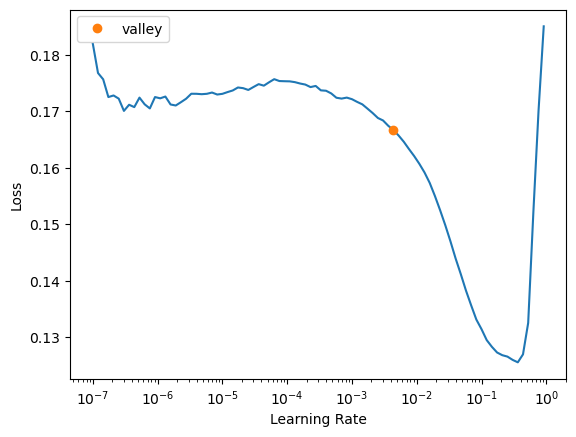

In [15]:
learn1.lr_find()

 I use learn1.lr_find() to find the best learning rate for training our model on medical images. This method tests different learning rates to see how they affect the model’s learning. It suggests the most effective rate, here 0.004365158267319202, which helps the model learn quickly and effectively without issues.

In [16]:
learn1.fine_tune(4, base_lr=0.004365158267319202)

epoch,train_loss,valid_loss,accuracy_multi,precision_multi,recall_multi,f1_score_multi,time
0,0.066080,0.017008,0.800933,0.100536,0.297119,0.149503,05:04


epoch,train_loss,valid_loss,accuracy_multi,precision_multi,recall_multi,f1_score_multi,time
0,0.018995,0.014946,0.775756,0.103806,0.369277,0.161220,04:32
1,0.015279,0.013269,0.761756,0.106401,0.405043,0.167268,04:03
2,0.013367,0.012641,0.771378,0.120826,0.420880,0.186187,04:19
3,0.012855,0.012587,0.769178,0.121787,0.441086,0.189886,04:40


Over four epochs, both the training and validation losses decreased, which means our model is learning well. We also saw improvements in precision, recall, and the F1 score, which tells us the model is getting better at correctly identifying and classifying different labels. By the final epoch, the model's ability to predict accurately had improved notably.

### MODEL2 resnet 50

In [18]:
learn2 = vision_learner(dls, resnet50, loss_func=FocalLoss(), metrics=[
    partial(accuracy_multi, thresh=0.25),
    partial(precision_multi, thresh=0.25),
    partial(recall_multi, thresh=0.25),
    partial(f1_score_multi, thresh=0.25)
])


SuggestedLRs(valley=0.002511886414140463)

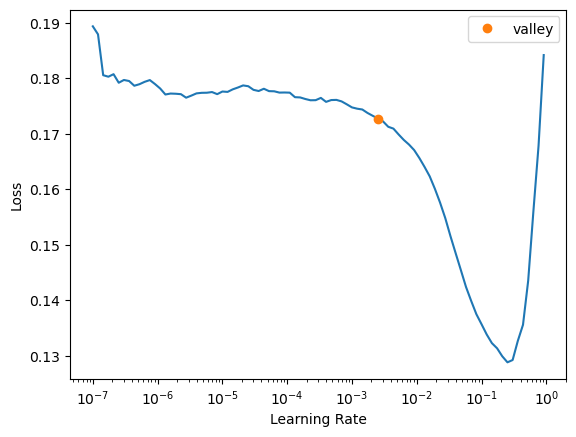

In [19]:
learn2.lr_find()

In [20]:
learn2.fine_tune(4, base_lr=0.002511886414140463)

epoch,train_loss,valid_loss,accuracy_multi,precision_multi,recall_multi,f1_score_multi,time
0,0.092836,0.019923,0.632333,0.088077,0.383477,0.142701,06:17


epoch,train_loss,valid_loss,accuracy_multi,precision_multi,recall_multi,f1_score_multi,time
0,0.025790,0.015920,0.844333,0.116460,0.271910,0.161874,07:02
1,0.018739,0.014336,0.815711,0.098203,0.304150,0.147359,06:42
2,0.015372,0.012937,0.808644,0.103374,0.323184,0.155496,07:18
3,0.014115,0.012775,0.800889,0.107562,0.352709,0.163759,07:37


our training results show significant improvements across various metrics over four epochs. The training and validation losses consistently decreased, indicating that the model was effectively learning from the data. Although the initial accuracy was low, it increased substantially, reaching up to 84.4% by the second epoch. Precision, recall, and the F1 score also improved. The increase in F1 score demonstrates better balance between precision and recall, confirming ResNet50’s effectiveness for multi-label classification tasks in our project.